# Project 9: Music genre recognition from spectrograms

## Task: Audio classification from the input spectrograms (treated as images)

### Students: Dalila Ladli, Camille Saran, Jorge Vásquez Mercado
### M2 TAL

In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torchvision
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import cv2

import glob
from tqdm import tqdm

### Step1: Download the data and preprocess it as required for the given task

DATA LOADING 

In [2]:
#LOADING THE DATA

img_path='archive/Data/images_original/'

image_paths=[] #We are storing the path of each spectogram in a list
genres=[] #We are storing the genres

#1. We are going to have the all the spect paths from img_path and genre to its respective lists
# eg. spect path-> 'archive/Data/images_original/blues/blues00078.png'
# eg. genre -> blues

for image_path in glob.glob(img_path + '/*'):
    genres.append(image_path.split('/')[-1]) 
    image_paths.append(glob.glob(image_path + '/*'))
    
image_paths = list(flatten(image_paths))
#random.shuffle(spect_paths)

print('spect_paths example: ', image_paths[0])
print('genre example: ', genres[0])


spect_paths example:  archive/Data/images_original/blues/blues00078.png
genre example:  blues


In [3]:
#We are creating a dictionary for genre indexes

idx_to_genre = {i:j for i, j in enumerate(genres)}
genre_to_idx = {value:key for key,value in idx_to_genre.items()}

print(idx_to_genre)

{0: 'blues', 1: 'disco', 2: 'pop', 3: 'country', 4: 'hiphop', 5: 'classical', 6: 'metal', 7: 'reggae', 8: 'rock', 9: 'jazz'}


In [4]:
#We are going to define a Transform function for the images
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

### Step2: Write a Dataset class for creating the train and test datasets (and corresponding dataloaders)

DATASET CLASS

In [5]:
#We are going to create our Dataset class

class GenreDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = genre_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [6]:
#We instanciate the dataset
genre_dataset=GenreDataset(image_paths,transform=data_transforms)
num_genre=len(genres)

print('The shape of tensor for 50th image in genre dataset: ', genre_dataset[49][0].shape)
print('The label for 50th image in genre dataset: ',genre_dataset[49][1])
print('Number of classes in the dataset:',num_genre)
print('Number of images in the genre dataset', len(genre_dataset))

The shape of tensor for 50th image in genre dataset:  torch.Size([3, 288, 432])
The label for 50th image in genre dataset:  0
Number of classes in the dataset: 10
Number of images in the genre dataset 999


In [7]:
#We get a data pair from the dataset
image, label = genre_dataset[0]
print(image.shape)
print('Image label=', label)

torch.Size([3, 288, 432])
Image label= 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


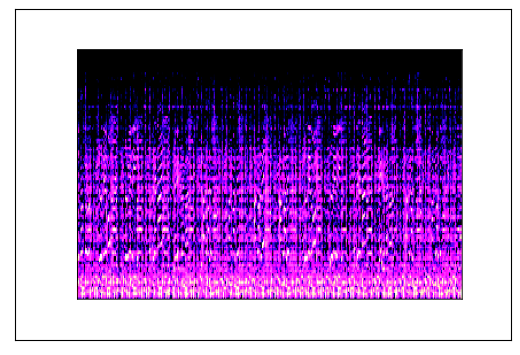

In [8]:
#We are going to plot the image
plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.xticks([]), plt.yticks([])
plt.show()

TRAIN, TEST AND VALIDATION DATASET 

In [9]:
#We create the train, test and validation dataset

train_len = int(len(genre_dataset)*0.7)
train_data, test_data = random_split(genre_dataset, [train_len, len(genre_dataset) - train_len])

n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

print("the size of train data is: ",len(train_data))
print("the size of test data is: ",len(test_data))
print("the size of valid data is: ",len(valid_data))

the size of train data is:  629
the size of test data is:  300
the size of valid data is:  70


In [10]:
#We create de dataloaders for the train, test and valid data
batch_size=8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

print('Dataloader train length (number of batches):', len(train_dataloader))

Dataloader train length (number of batches): 79


In [11]:
# Get a batch of images and corresponding labels from the genre dataloader
#batch_example = next(iter(genre_dataloader))
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 3, 288, 432])
torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


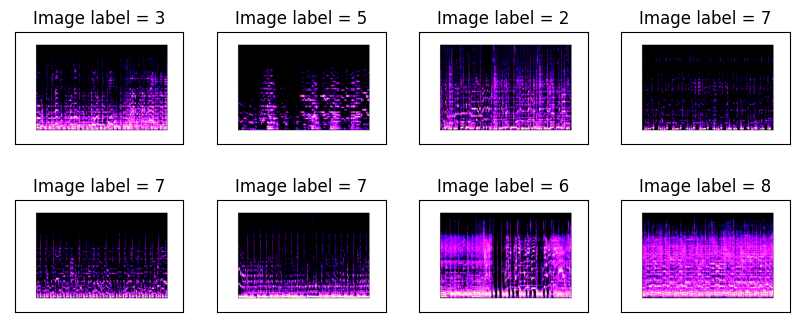

In [12]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,4))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].permute(1, 2, 0))
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

### Step3: Define the neural network model

NEURAL NETWORK MODEL

In [13]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [14]:
# We define the CNN classification network

class CNNClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif, self).__init__()
        self.input_layer=nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=3))
        self.hidden_layer1=nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=3))
        self.hidden_layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=3))
        self.output_layer=nn.Sequential(nn.Linear(8640, num_classes))
        
    def forward(self, x):
        inp=self.input_layer(x)
        hid1=self.hidden_layer1(inp)
        hid=self.hidden_layer2(hid1)
        hid=hid.reshape(hid.shape[0], -1)
        out=self.output_layer(hid)
        return out 

### Step4: Define the hyperparameters to create an instance of the model

INSTANCE OF THE MODEL

In [15]:
# We instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization (ensure reproducibility: everybody should have the same results)
torch.manual_seed(0)
model.apply(init_weights)

Total number of parameters:  151722


CNNClassif(
  (input_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=8640, out_features=10, bias=True)
  )
)

### Step5: Write the training loop for training the model

TRAINING MODEL


In [16]:
def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            #vectorized_image=images.reshape(size[0], size[1]*size[2]*size[3])
            
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            predicted_label=model_tr(images)
            
            # - use the 'backward' method to compute the gradients
            l=loss_fn(predicted_label, labels)
            l.backward()
            # - apply the gradient descent algorithm
            optimizer.step()
            optimizer.zero_grad()
            # Also think of updating the loss at the current epoch
            
            loss_current_epoch+=l.item()
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

Epoch [1/30], Loss: 175.8505
Epoch [2/30], Loss: 156.2609
Epoch [3/30], Loss: 139.0565
Epoch [4/30], Loss: 125.2697
Epoch [5/30], Loss: 110.2324
Epoch [6/30], Loss: 95.9169
Epoch [7/30], Loss: 86.5423
Epoch [8/30], Loss: 75.8630
Epoch [9/30], Loss: 68.3020
Epoch [10/30], Loss: 55.2733
Epoch [11/30], Loss: 47.7646
Epoch [12/30], Loss: 34.9529
Epoch [13/30], Loss: 25.6544
Epoch [14/30], Loss: 16.5039
Epoch [15/30], Loss: 15.7500
Epoch [16/30], Loss: 5.0759
Epoch [17/30], Loss: 1.8815
Epoch [18/30], Loss: 1.3607
Epoch [19/30], Loss: 0.8074
Epoch [20/30], Loss: 0.6124
Epoch [21/30], Loss: 0.5181
Epoch [22/30], Loss: 0.4514
Epoch [23/30], Loss: 0.3849
Epoch [24/30], Loss: 0.3327
Epoch [25/30], Loss: 0.2972
Epoch [26/30], Loss: 0.2682
Epoch [27/30], Loss: 0.2429
Epoch [28/30], Loss: 0.2248
Epoch [29/30], Loss: 0.2094
Epoch [30/30], Loss: 0.1909


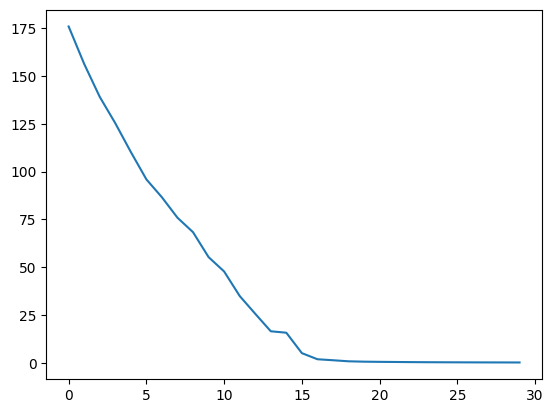

In [17]:
# Optimizer
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

# Training
model, loss_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the loss over epochs

plt.plot(loss_total)
plt.show()

### Step6: Evaluate the model on the test data.

EVALUATION OF THE MODEL

In [18]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader):

    # Set the model in evaluation mode
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [19]:
test_model=eval_cnn_classifier(model,test_dataloader)
print('The test accuracy is: '+ str(test_model)+'%')

The test accuracy is: 61.333333333333336%


### Step7: Save the trained model parameters
SAVING THE MODEL

In [20]:
# Save the model 
torch.save(model.state_dict(), 'model_cnn_genre_classif_final.pt')
#load the model
#model.load_state_dict(torch.load('model_cnn_genre_classif_final.pt'))

In [21]:
image_test = cv2.imread('jazz00014.png')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test = data_transforms(image_test)

In [22]:
image_test.shape

torch.Size([3, 288, 432])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 288, 432])


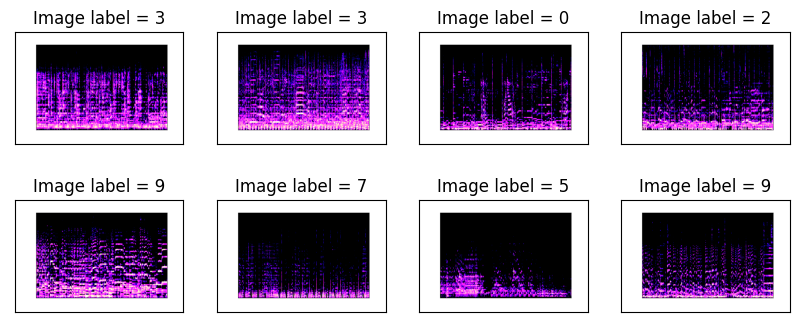

In [23]:
#for batch_index, (images, labels) in enumerate(train_dataloader):
for batch_index, (images, labels) in enumerate(valid_dataloader):    
    print(images.shape)
    prueba1=images
    prueba1_l=labels
    
    break

plt.figure(figsize = (10,4))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(prueba1[ib, :].permute(1, 2, 0))
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(prueba1_l[ib].item()))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 8, 0, 2, 9, 7, 9, 9])


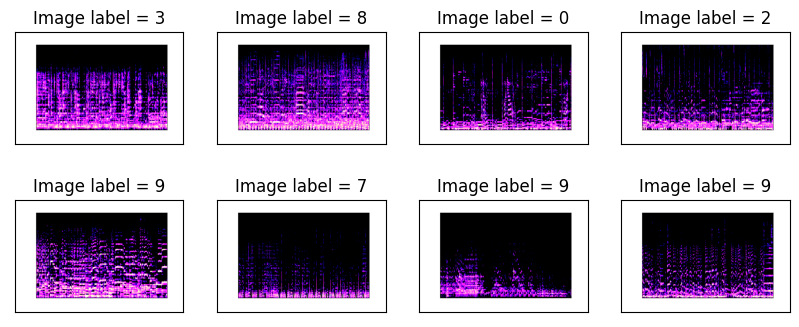

In [24]:
#Prediction of a batch
predicted=model(prueba1)
_, genre_predicted = torch.max(predicted.data, 1)
print(genre_predicted)
plt.figure(figsize = (10,4))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(prueba1[ib, :].permute(1, 2, 0))
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(genre_predicted[ib].item()))
plt.show()

### Bonus Experiment (here we want to try the same model using Batch Normalization)

TEST CNN WITH BATCH NORMALIZATION (LOWER RESULTS)

In [25]:
#Defining a CNN with batch normalization

class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        self.input_layer=nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=3))
        self.hidden_layer1=nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=3))
        self.hidden_layer2=nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, padding=1),
                           nn.ReLU(),
                           nn.BatchNorm2d(64),
                           nn.MaxPool2d(kernel_size=3))
        self.output_layer=nn.Sequential(nn.Linear(8640, num_classes))
    def forward(self, x):
        inp=self.input_layer(x)
        hid1=self.hidden_layer1(inp)
        hid=self.hidden_layer2(hid1)
        hid=hid.reshape(hid.shape[0], -1)
        out=self.output_layer(hid)
        return out

Epoch [1/30], Loss: 1361.6714
Epoch [2/30], Loss: 596.8607
Epoch [3/30], Loss: 284.4045
Epoch [4/30], Loss: 198.8501
Epoch [5/30], Loss: 144.5733
Epoch [6/30], Loss: 114.1439
Epoch [7/30], Loss: 94.5322
Epoch [8/30], Loss: 80.2542
Epoch [9/30], Loss: 66.6057
Epoch [10/30], Loss: 52.2288
Epoch [11/30], Loss: 45.2018
Epoch [12/30], Loss: 29.6953
Epoch [13/30], Loss: 29.0700
Epoch [14/30], Loss: 18.9496
Epoch [15/30], Loss: 15.5582
Epoch [16/30], Loss: 11.2279
Epoch [17/30], Loss: 4.6805
Epoch [18/30], Loss: 5.5077
Epoch [19/30], Loss: 2.5137
Epoch [20/30], Loss: 2.7663
Epoch [21/30], Loss: 2.6528
Epoch [22/30], Loss: 1.7271
Epoch [23/30], Loss: 1.2196
Epoch [24/30], Loss: 0.9431
Epoch [25/30], Loss: 0.8178
Epoch [26/30], Loss: 0.6604
Epoch [27/30], Loss: 0.5261
Epoch [28/30], Loss: 0.4896
Epoch [29/30], Loss: 0.4501
Epoch [30/30], Loss: 0.3705


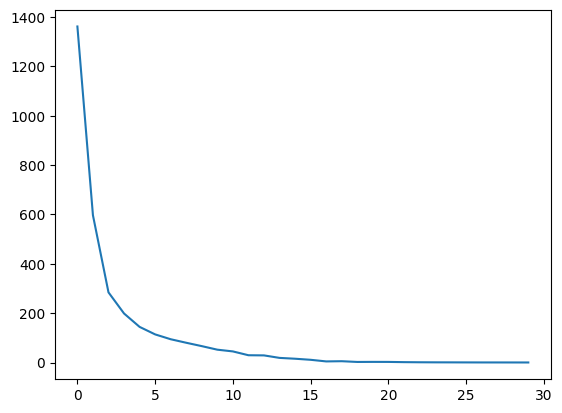

Accuracy of the network on the test images:  59.0 %


In [26]:
model_bn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
torch.manual_seed(0)
model_bn.apply(init_weights)

model_bn, loss_total = training_cnn_classifier(model_bn, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)
torch.save(model_bn.state_dict(), 'model_cnn_genre_classif_bn_final.pt')
plt.plot(loss_total)
plt.show()

accuracy_bn = eval_cnn_classifier(model_bn, test_dataloader)
print('Accuracy of the network on the test images: ', accuracy_bn, '%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 8, 3, 2, 9, 7, 9, 9])


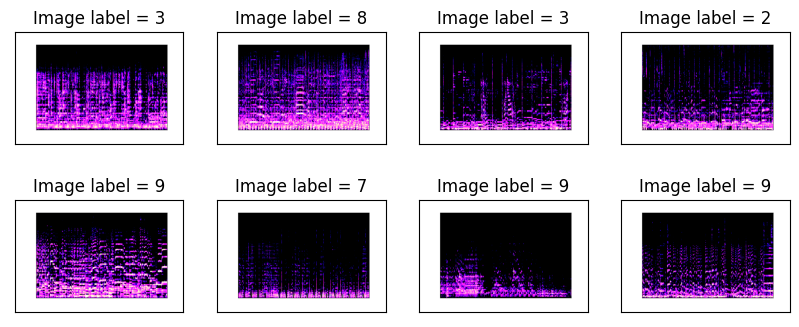

In [27]:
#Prediction of a batch
predicted=model_bn(prueba1)
_, genre_predicted = torch.max(predicted.data, 1)
print(genre_predicted)
plt.figure(figsize = (10,4))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(prueba1[ib, :].permute(1, 2, 0))
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(genre_predicted[ib].item()))
plt.show()

### Conclusion of the extra experiment

The results show us that our CNN has a better accuracy that using the same CNN with Batch Normalization

CNN accuracy = 61.3%

CNN BatchNormalization= 59.0%